Ahmet Aytac z23728331 11/26/2025 CAP4770


Assignment 5: Deep Learning for Ocean Sound Classification

Objective

The goal of this assignment is to build and evaluate multiple deep learning models for ocean sound classification. You will use the dataset provided in the Files section on Canvas, which contains WAV audio clips and a CSV file of labels. Your task is to explore how different deep learning approaches perform when classifying marine mammal sounds recorded in ocean environments.

The assignment emphasizes:

Understanding audio preprocessing

Using spectrograms as input features

Comparing different neural network families

Evaluating performance across several deep learning methods

Observing how models behave with and without time–frequency representations

Dataset
The dataset is available inside the course’s Files section on Canvas. It includes:

A folder of WAV audio clips extracted from the Watkins Marine Mammal Sound (WMMS) dataset.

A CSV file with labels for each audio file.

You are free to organize the dataset into training, validation, and testing splits as you see appropriate.

Tasks
Task 1 – Spectrogram + DNN
Convert each audio clip into a spectrogram (any implementation is acceptable). Train a deep neural network using the spectrograms as input. Report and discuss your results.

Task 2 – Spectrogram + CNN
Use the same spectrogram representations and train a convolution-based model for classification. Compare your results to Task 1.

Task 3 – Spectrogram + RNN
Treat the spectrogram as a sequence over time. Train a recurrent-based model and evaluate its performance. Compare with previous tasks.

Task 4 – Spectrogram + LSTM
Repeat the process using an LSTM-based model. Report improvements or declines compared to earlier models.

Task 5 – Spectrogram + Transformer Model
Apply a transformer-based approach to classify the spectrograms. Analyze how well it performs on this audio dataset relative to the other methods.

Task 6 – Classification Without Spectrograms
Train a deep learning model directly from the raw WAV waveform, without spectrograms. You may use any method you choose. Compare your results to the spectrogram-based approaches.

What to Submit
Code notebook (Jupyter/Colab) containing:

Data loading

Preprocessing

Training for each task

Evaluation and plots



Comparisons between tasks
Discussion of what worked best and why


Notes
You may choose any hyperparameters, library functions, and training strategies you prefer.

You are encouraged to include confusion matrices, accuracy curves, or any other evaluation metrics.

You may work on each task independently , there is no requirement that one model must build on another.

In [ ]:
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "librosa", "matplotlib", "numpy", "pandas", "scikit-learn", "tensorflow", "tqdm", "seaborn", "rarfile", "-q"])

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

np.random.seed(42)
tf.random.set_seed(42)

from google.colab import files

In [ ]:

print("Upload CSV file:")
uploaded = files.upload()
LABELS_CSV = list(uploaded.keys())[0]

print("\nUpload audio archive (ZIP or RAR):")
uploaded_archive = files.upload()
archive_file = list(uploaded_archive.keys())[0]

os.makedirs('audio_clips', exist_ok=True)

if archive_file.endswith('.zip'):
    import zipfile
    with zipfile.ZipFile(archive_file, 'r') as zip_ref:
        zip_ref.extractall('audio_clips/')
elif archive_file.endswith('.rar'):
    import rarfile
    with rarfile.RarFile(archive_file, 'r') as rar_ref:
        rar_ref.extractall('audio_clips/')

extracted_files = []
for root, dirs, files_list in os.walk('audio_clips'):
    for file in files_list:
        if file.endswith('.wav'):
            extracted_files.append(os.path.join(root, file))

if len(extracted_files) > 0:
    AUDIO_DIR = os.path.dirname(extracted_files[0]) + '/'
else:
    AUDIO_DIR = 'audio_clips/'

print(f"\nFound {len(extracted_files)} audio files")

Upload CSV file:


Saving wmms_labels.csv to wmms_labels (1).csv

Upload audio archive (ZIP or RAR):


Saving wmms_audio.rar to wmms_audio.rar

Found 1357 audio files


In [ ]:

SAMPLE_RATE = 22050
DURATION = 5
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
BATCH_SIZE = 32
EPOCHS = 50
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15
LEARNING_RATE = 0.001

labels_df = pd.read_csv(LABELS_CSV)


if 'label_id' in labels_df.columns:
    label_column = 'label_id'
elif 'label' in labels_df.columns:
    label_column = 'label'
else:
    label_column = labels_df.columns[1]

num_classes = labels_df[label_column].nunique()
print(f"Classes: {num_classes}")


Classes: 32


In [ ]:

def load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION):
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
        target_length = sr * duration
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]
        return audio
    except:
        return None

def compute_melspectrogram(audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def prepare_dataset(df, audio_dir, use_spectrogram=True):
    features = []
    labels = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        filename = row['file']

        possible_paths = [
            os.path.join(audio_dir, filename),
            os.path.join('audio_clips', filename),
            filename
        ]

        for root, dirs, files_list in os.walk('audio_clips'):
            possible_paths.append(os.path.join(root, filename))

        file_path = None
        for path in possible_paths:
            if os.path.exists(path):
                file_path = path
                break

        if file_path is None:
            continue

        audio = load_audio_file(file_path)
        if audio is None:
            continue

        if use_spectrogram:
            feature = compute_melspectrogram(audio)
        else:
            feature = audio

        features.append(feature)
        labels.append(row[label_column])

    X = np.array(features)
    y = np.array(labels)

    return X, y

X_spec, y = prepare_dataset(labels_df, AUDIO_DIR, use_spectrogram=True)
y_categorical = to_categorical(y, num_classes=num_classes)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_spec, y_categorical, test_size=TEST_SPLIT, random_state=42, stratify=y
)

val_size_adjusted = VALIDATION_SPLIT / (1 - TEST_SPLIT)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_size_adjusted,
    random_state=42, stratify=np.argmax(y_train_val, axis=1)
)

def plot_history(history, name):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Val')
    axes[0].set_title(f'{name} - Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Val')
    axes[1].set_title(f'{name} - Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def evaluate(model, X_test, y_test, name):
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true, y_pred)
    print(f"{name} Accuracy: {acc:.4f} ({acc*100:.2f}%)")

    print(classification_report(y_true, y_pred, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

    return acc

def get_callbacks():
    return [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
    ]


100%|██████████| 1357/1357 [00:46<00:00, 28.99it/s]



TASK 1: DNN
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.0699 - loss: 4.1461 - val_accuracy: 0.0098 - val_loss: 25.3315 - learning_rate: 0.0010
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0992 - loss: 3.5919 - val_accuracy: 0.0098 - val_loss: 18.1302 - learning_rate: 0.0010
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1518 - loss: 3.3238 - val_accuracy: 0.0147 - val_loss: 9.0859 - learning_rate: 0.0010
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1654 - loss: 3.1908 - val_accuracy: 0.0294 - val_loss: 6.2062 - learning_rate: 0.0010
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1509 - loss: 3.1166 - val_accuracy: 0.1127 - val_loss: 4.6148 - learning_rate: 0.0010
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1692 - loss: 2.9625 - val_accuracy: 0.1716 - val_loss: 3.4059 - learning_rate: 0.0010
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1781 - loss:

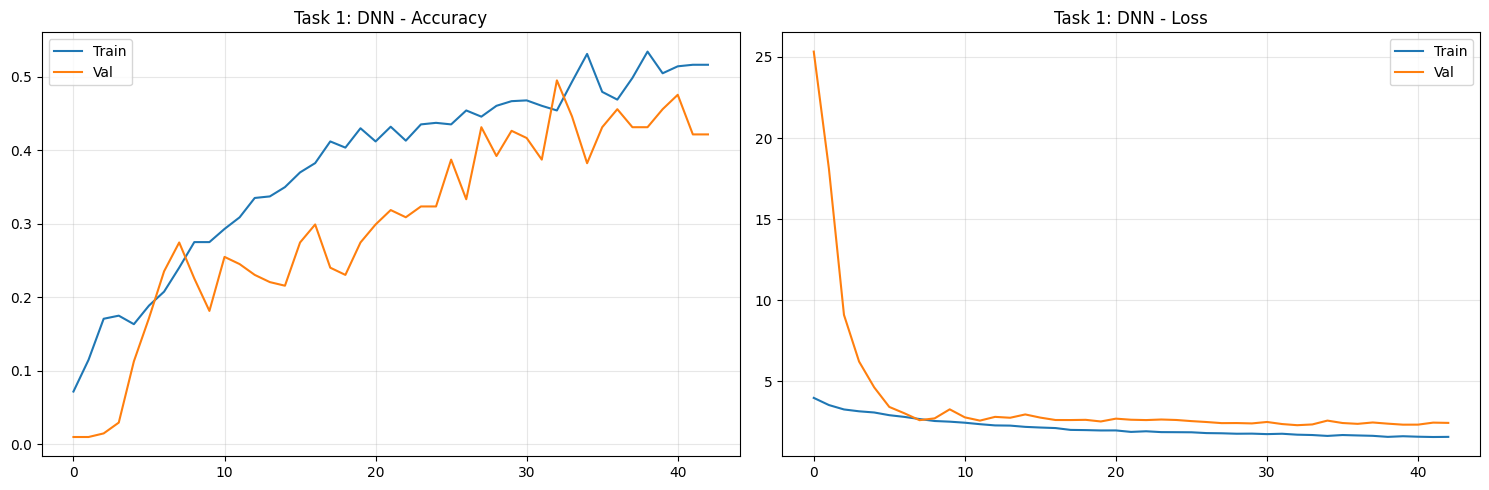

Task 1: DNN Accuracy: 0.5441 (54.41%)
              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.00      0.00      0.00         4
           2       1.00      0.50      0.67         6
           3       0.00      0.00      0.00         3
           4       0.78      1.00      0.88         7
           5       0.70      0.88      0.78         8
           6       0.00      0.00      0.00         6
           7       0.20      0.14      0.17         7
           8       1.00      1.00      1.00         6
           9       0.64      0.90      0.75        10
          10       0.50      0.75      0.60         8
          11       0.55      1.00      0.71         6
          12       0.75      0.75      0.75         8
          13       0.00      0.00      0.00         4
          14       1.00      1.00      1.00         1
          15       0.18      0.38      0.24         8
          16       0.43      0.75      0.55

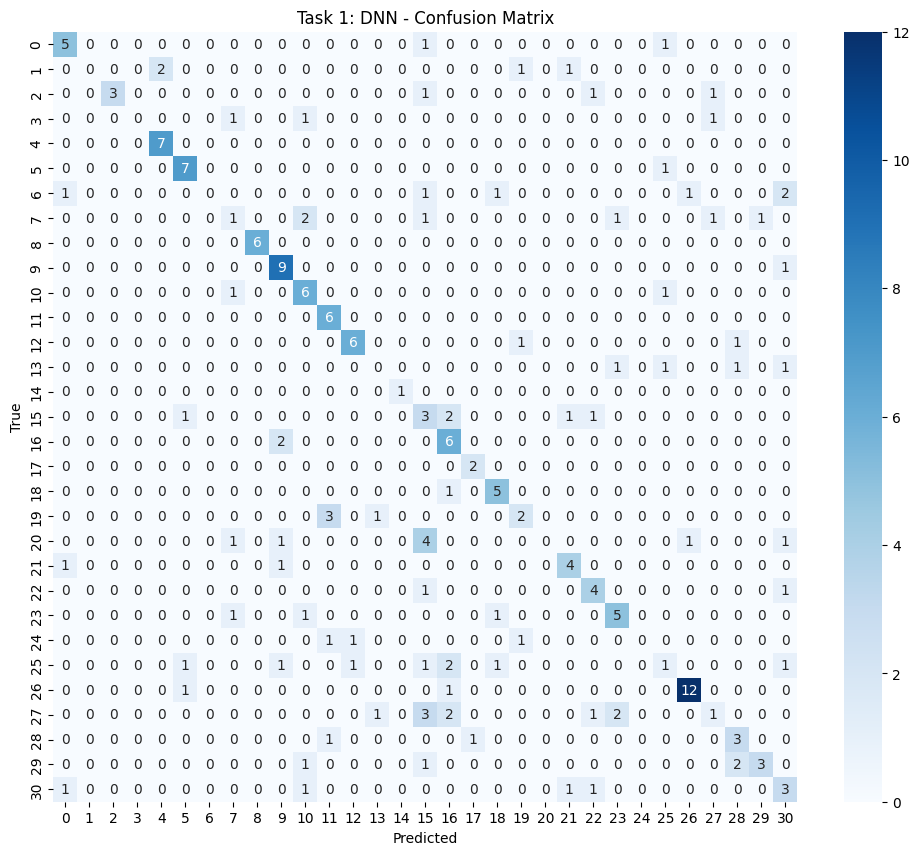

In [ ]:
print("\nTASK 1: DNN")

X_train_dnn = X_train.reshape(X_train.shape[0], -1)
X_val_dnn = X_val.reshape(X_val.shape[0], -1)
X_test_dnn = X_test.reshape(X_test.shape[0], -1)

model_dnn = models.Sequential([
    layers.Input(shape=(X_train_dnn.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model_dnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_dnn = model_dnn.fit(
    X_train_dnn, y_train,
    validation_data=(X_val_dnn, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=get_callbacks(),
    verbose=1
)

plot_history(history_dnn, 'Task 1: DNN')
acc_dnn = evaluate(model_dnn, X_test_dnn, y_test, 'Task 1: DNN')



TASK 2: CNN
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 729ms/step - accuracy: 0.0458 - loss: 4.4174 - val_accuracy: 0.0196 - val_loss: 11.0474 - learning_rate: 0.0010
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.1396 - loss: 3.6043 - val_accuracy: 0.0441 - val_loss: 6.9242 - learning_rate: 0.0010
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.2281 - loss: 3.0151 - val_accuracy: 0.1373 - val_loss: 3.1301 - learning_rate: 0.0010
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.2778 - loss: 2.7370 - val_accuracy: 0.1569 - val_loss: 3.5404 - learning_rate: 0.0010
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.3240 - loss: 2.4115 - val_accuracy: 0.3284 - val_loss: 2.4622 - learning_rate: 0.0010
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.3939 - loss: 2.1840 - val_accuracy: 0.2549 - val_loss: 2.9221 - learning_rate: 0.0010
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.4424 - loss: 

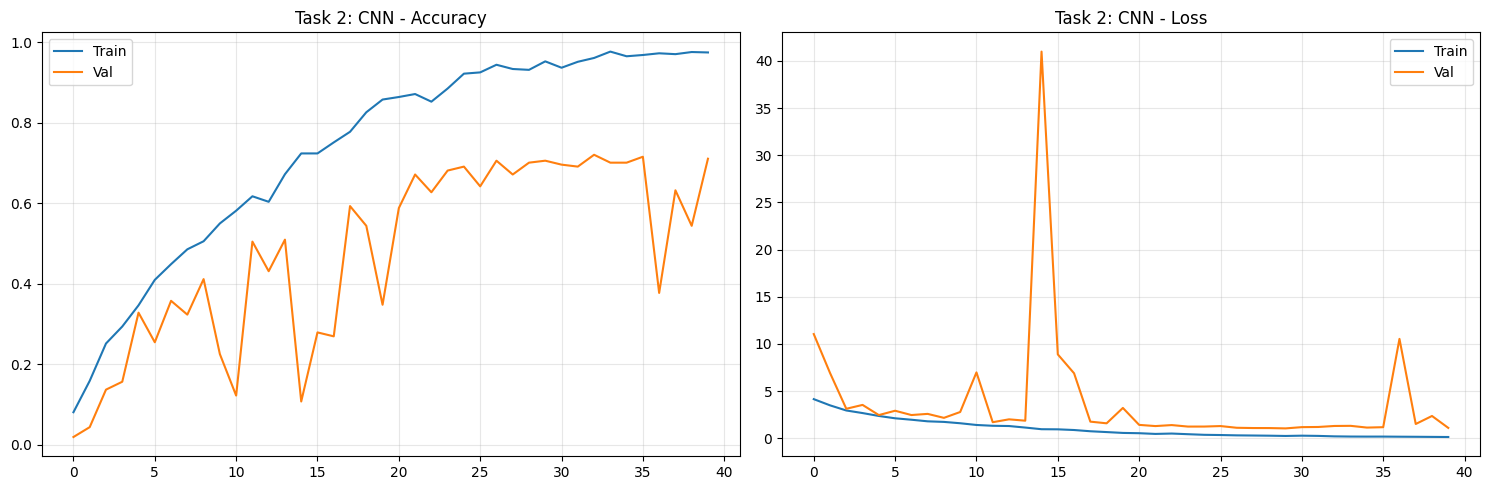

Task 2: CNN Accuracy: 0.7500 (75.00%)
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       1.00      0.25      0.40         4
           2       0.80      0.67      0.73         6
           3       0.75      1.00      0.86         3
           4       0.70      1.00      0.82         7
           5       0.88      0.88      0.88         8
           6       0.30      0.50      0.38         6
           7       1.00      0.43      0.60         7
           8       1.00      1.00      1.00         6
           9       0.82      0.90      0.86        10
          10       0.67      0.75      0.71         8
          11       0.71      0.83      0.77         6
          12       1.00      0.88      0.93         8
          13       0.60      0.75      0.67         4
          14       1.00      1.00      1.00         1
          15       0.62      0.62      0.62         8
          16       0.73      1.00      0.84

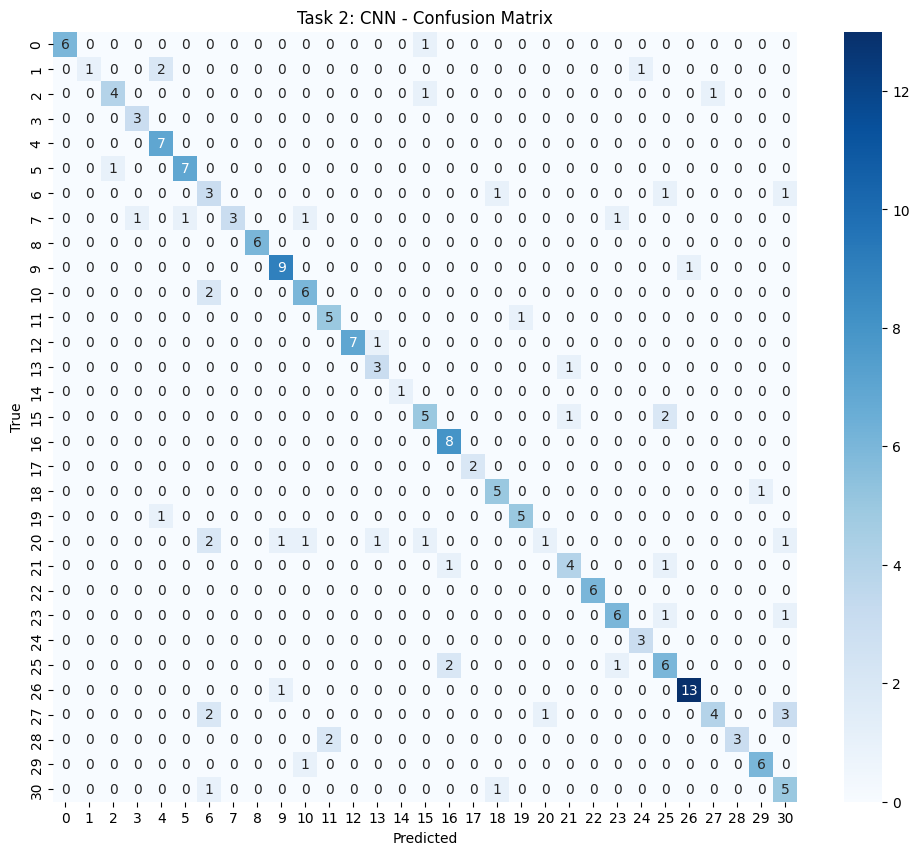

In [ ]:

print("\nTASK 2: CNN")

X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

model_cnn = models.Sequential([
    layers.Input(shape=X_train_cnn.shape[1:]),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn = model_cnn.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=get_callbacks(),
    verbose=1
)

plot_history(history_cnn, 'Task 2: CNN')
acc_cnn = evaluate(model_cnn, X_test_cnn, y_test, 'Task 2: CNN')



TASK 3: RNN
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 459ms/step - accuracy: 0.0237 - loss: 4.6897 - val_accuracy: 0.0049 - val_loss: 3.5580 - learning_rate: 5.0000e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.0376 - loss: 4.5284 - val_accuracy: 0.0049 - val_loss: 3.5002 - learning_rate: 5.0000e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.0442 - loss: 4.3881 - val_accuracy: 0.0343 - val_loss: 3.4987 - learning_rate: 5.0000e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.0368 - loss: 4.2444 - val_accuracy: 0.0343 - val_loss: 3.5191 - learning_rate: 5.0000e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.0311 - loss: 4.2569 - val_accuracy: 0.0294 - val_loss: 3.5920 - learning_rate: 5.0000e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.0324 - loss: 4.2753 - val_accuracy: 0.0588 - val_loss: 3.4760 - learning_rate: 5.0000e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/ste

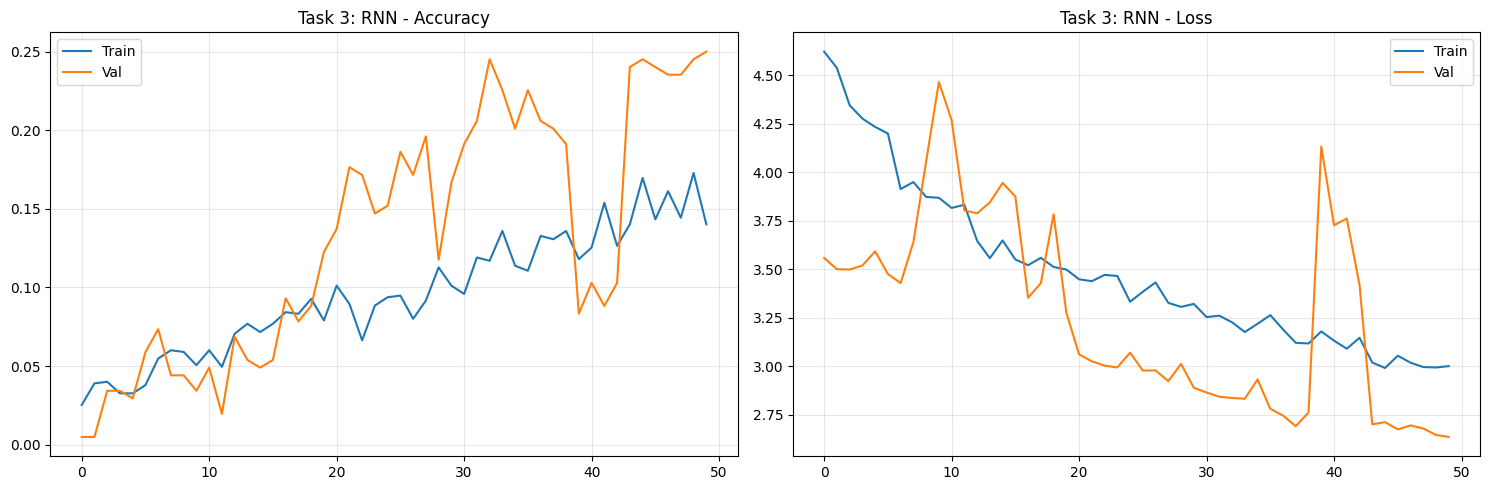

Task 3: RNN Accuracy: 0.2157 (21.57%)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         3
           4       1.00      0.29      0.44         7
           5       0.80      0.50      0.62         8
           6       0.00      0.00      0.00         6
           7       0.25      0.14      0.18         7
           8       0.43      1.00      0.60         6
           9       0.00      0.00      0.00        10
          10       0.12      0.12      0.12         8
          11       0.36      0.83      0.50         6
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         8
          16       0.33      0.25      0.29

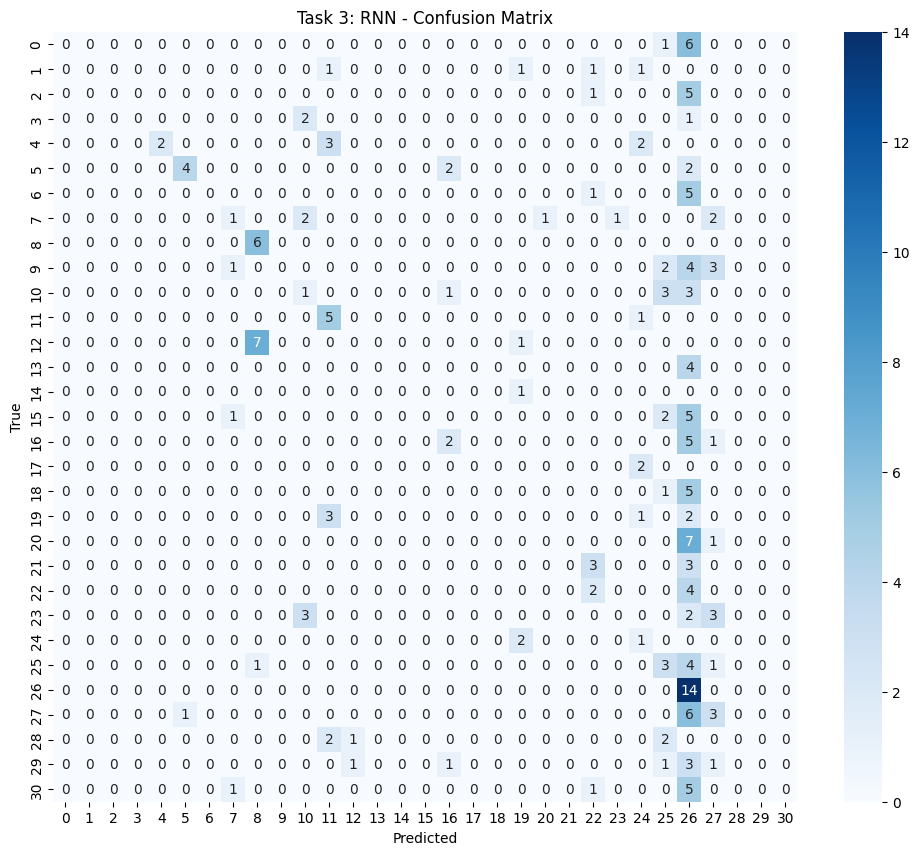

In [ ]:

print("\nTASK 3: RNN")

X_train_rnn = np.transpose(X_train, (0, 2, 1))
X_val_rnn = np.transpose(X_val, (0, 2, 1))
X_test_rnn = np.transpose(X_test, (0, 2, 1))

model_rnn = models.Sequential([
    layers.Input(shape=X_train_rnn.shape[1:]),

    layers.Bidirectional(layers.SimpleRNN(256, return_sequences=True)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Bidirectional(layers.SimpleRNN(128, return_sequences=True)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Bidirectional(layers.SimpleRNN(64)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

model_rnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE * 0.5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_rnn = model_rnn.fit(
    X_train_rnn, y_train,
    validation_data=(X_val_rnn, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=get_callbacks(),
    verbose=1
)

plot_history(history_rnn, 'Task 3: RNN')
acc_rnn = evaluate(model_rnn, X_test_rnn, y_test, 'Task 3: RNN')



TASK 4: LSTM
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.0205 - loss: 4.6147 - val_accuracy: 0.0490 - val_loss: 3.4417 - learning_rate: 5.0000e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.0509 - loss: 4.4708 - val_accuracy: 0.0686 - val_loss: 3.4339 - learning_rate: 5.0000e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.0350 - loss: 4.2259 - val_accuracy: 0.0784 - val_loss: 3.4519 - learning_rate: 5.0000e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.0655 - loss: 4.0507 - val_accuracy: 0.0490 - val_loss: 3.4434 - learning_rate: 5.0000e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.0601 - loss: 4.0675 - val_accuracy: 0.0686 - val_loss: 3.4687 - learning_rate: 5.0000e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.0450 - loss: 4.0603 - val_accuracy: 0.0490 - val_loss: 3.4308 - learning_rate: 5.0000e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - a

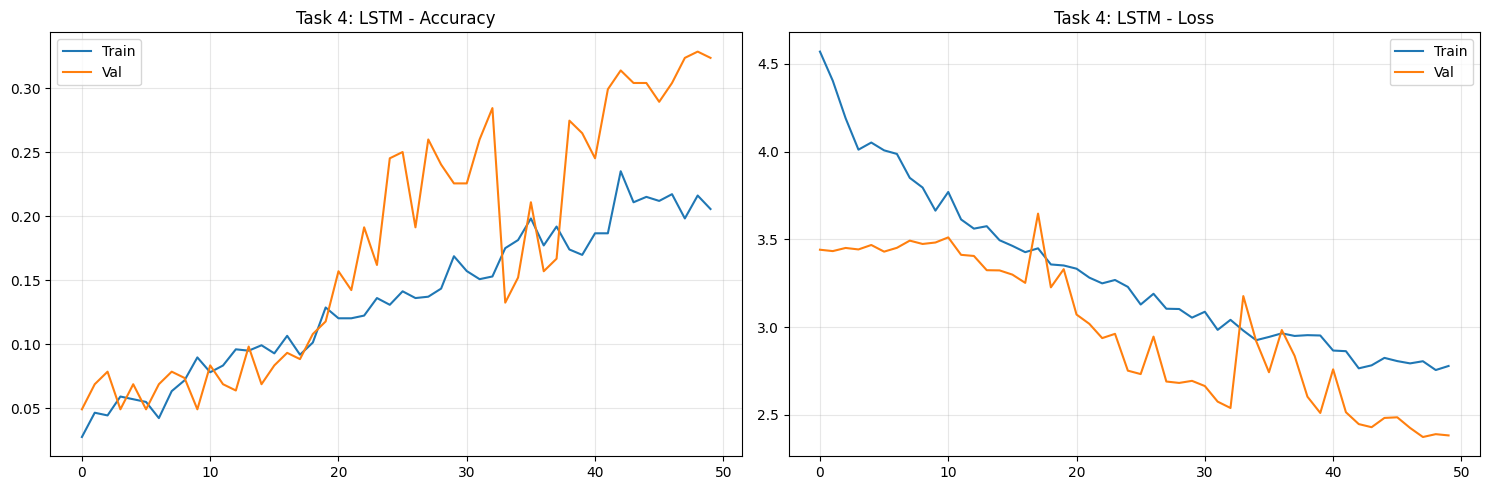

Task 4: LSTM Accuracy: 0.2892 (28.92%)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         3
           4       0.44      0.57      0.50         7
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         7
           8       0.67      1.00      0.80         6
           9       0.22      0.20      0.21        10
          10       0.33      0.38      0.35         8
          11       0.32      1.00      0.48         6
          12       0.38      0.38      0.38         8
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         8
          16       0.33      0.75      0.4

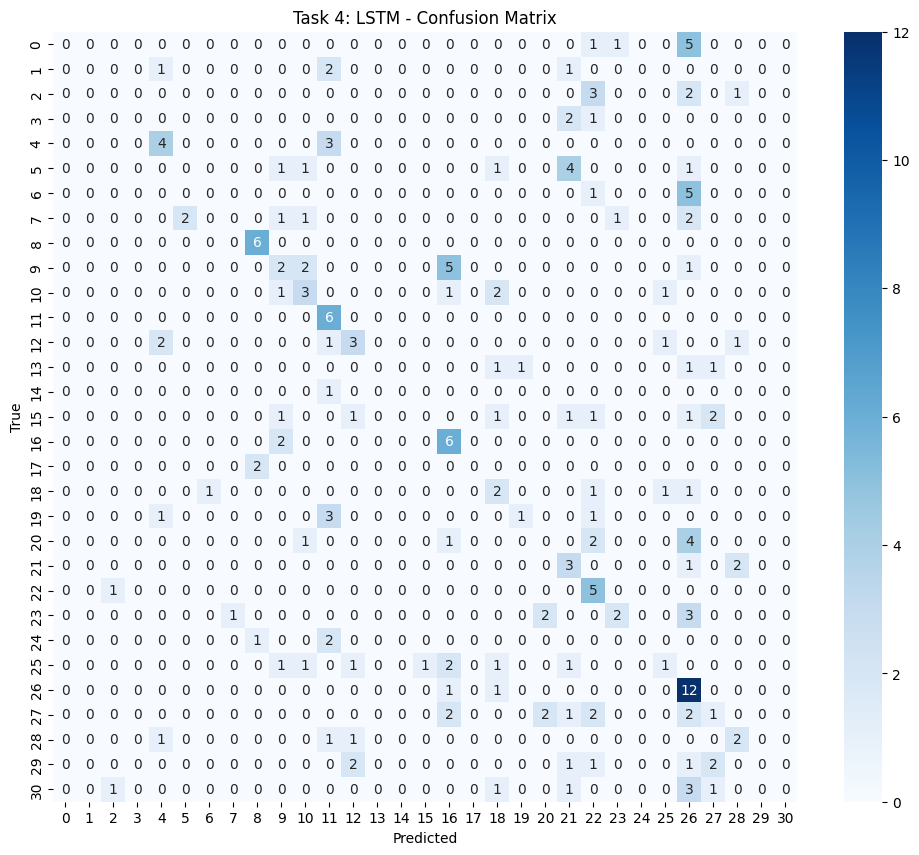

In [ ]:

print("\nTASK 4: LSTM")

model_lstm = models.Sequential([
    layers.Input(shape=X_train_rnn.shape[1:]),

    layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Bidirectional(layers.LSTM(64)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

model_lstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE * 0.5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_lstm = model_lstm.fit(
    X_train_rnn, y_train,
    validation_data=(X_val_rnn, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=get_callbacks(),
    verbose=1
)

plot_history(history_lstm, 'Task 4: LSTM')
acc_lstm = evaluate(model_lstm, X_test_rnn, y_test, 'Task 4: LSTM')



TASK 5: TRANSFORMER
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.0260 - loss: 3.6671 - val_accuracy: 0.0441 - val_loss: 3.4487 - learning_rate: 0.0010
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0470 - loss: 3.4567 - val_accuracy: 0.0686 - val_loss: 3.4341 - learning_rate: 0.0010
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0473 - loss: 3.4526 - val_accuracy: 0.0490 - val_loss: 3.4417 - learning_rate: 0.0010
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0621 - loss: 3.4404 - val_accuracy: 0.0686 - val_loss: 3.4405 - learning_rate: 0.0010
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0712 - loss: 3.4402 - val_accuracy: 0.0686 - val_loss: 3.4378 - learning_rate: 0.0010
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0659 - loss: 3.4312 - val_accuracy: 0.0686 - val_loss: 3.4157 - learning_rate: 0.0010
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0609 -

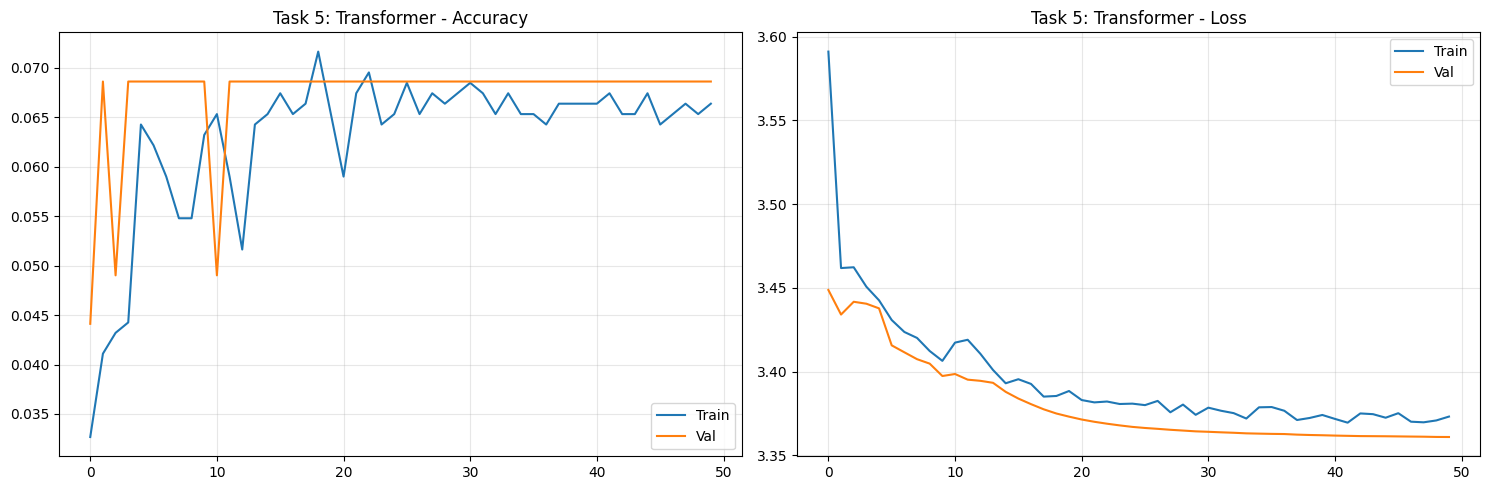

Task 5: Transformer Accuracy: 0.0686 (6.86%)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         8
          16       0.00      0.00   

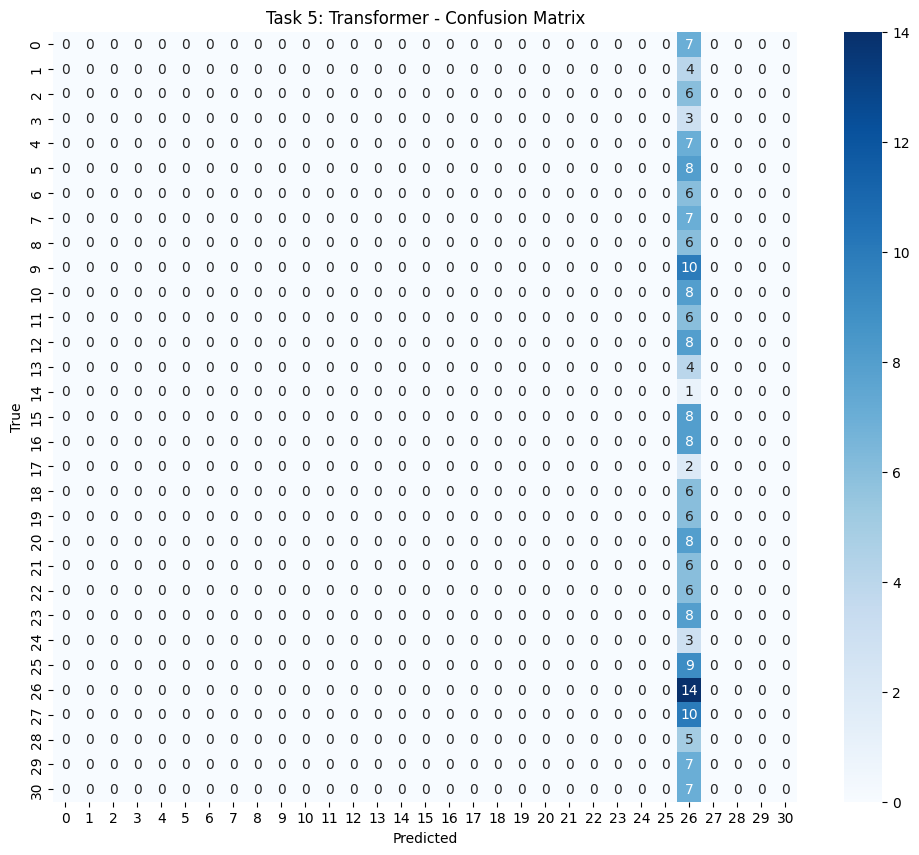

In [ ]:

print("\nTASK 5: TRANSFORMER")

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(128)(inputs)

    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    position_embedding = layers.Embedding(input_dim=input_shape[0], output_dim=128)(positions)
    x = x + position_embedding

    x = TransformerBlock(128, 4, 128)(x)
    x = TransformerBlock(128, 4, 128)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

model_transformer = build_transformer_model(X_train_rnn.shape[1:], num_classes)
model_transformer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_transformer = model_transformer.fit(
    X_train_rnn, y_train,
    validation_data=(X_val_rnn, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=get_callbacks(),
    verbose=1
)

plot_history(history_transformer, 'Task 5: Transformer')
acc_transformer = evaluate(model_transformer, X_test_rnn, y_test, 'Task 5: Transformer')



TASK 6: RAW AUDIO


100%|██████████| 1357/1357 [00:04<00:00, 324.01it/s]


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 809ms/step - accuracy: 0.0365 - loss: 4.5588 - val_accuracy: 0.0294 - val_loss: 3.4875 - learning_rate: 1.0000e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.0461 - loss: 4.3513 - val_accuracy: 0.0294 - val_loss: 3.5168 - learning_rate: 1.0000e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.0585 - loss: 4.2322 - val_accuracy: 0.0294 - val_loss: 3.5523 - learning_rate: 1.0000e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.0778 - loss: 4.1094 - val_accuracy: 0.0294 - val_loss: 3.6232 - learning_rate: 1.0000e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.0989 - loss: 3.9159 - val_accuracy: 0.0294 - val_loss: 3.7342 - learning_rate: 1.0000e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.0799 - loss: 3.9962 - val_accuracy: 0.0294 - val_loss: 4.0074 - learning_rate: 1.0000e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy:

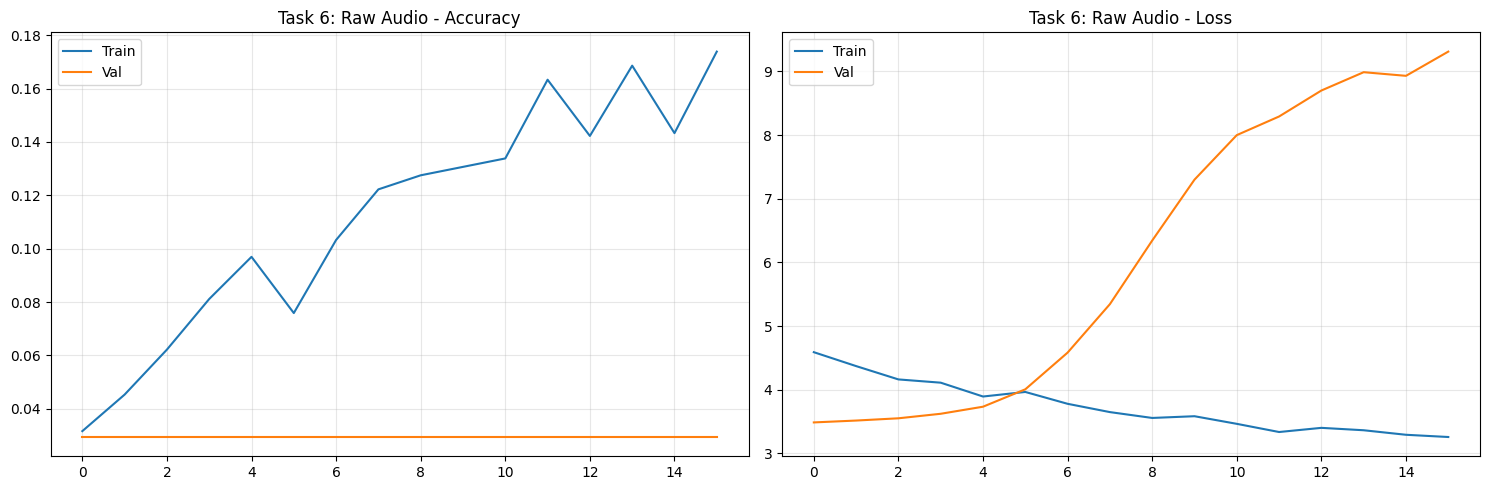

Task 6: Raw Audio Accuracy: 0.0294 (2.94%)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         7
           8       0.03      1.00      0.06         6
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         8
          16       0.00      0.00     

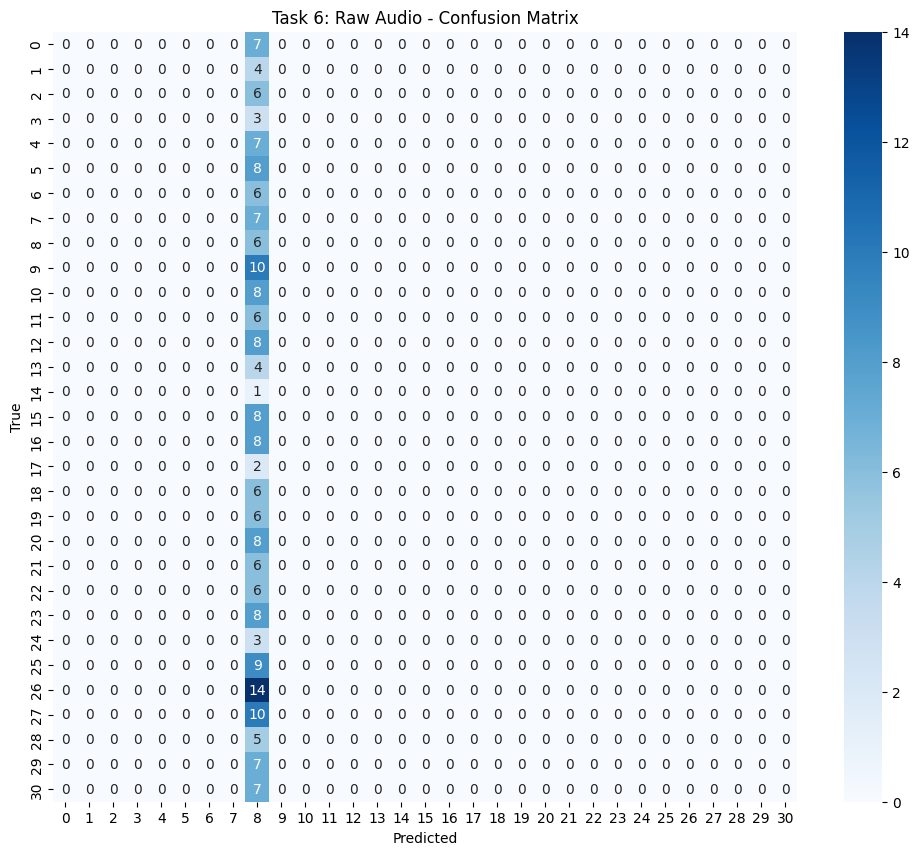

In [ ]:

print("\nTASK 6: RAW AUDIO")

X_raw, y_raw = prepare_dataset(labels_df, AUDIO_DIR, use_spectrogram=False)
y_raw_categorical = to_categorical(y_raw, num_classes=num_classes)

X_train_raw_full, X_test_raw, y_train_raw_full, y_test_raw = train_test_split(
    X_raw, y_raw_categorical, test_size=TEST_SPLIT, random_state=42, stratify=y_raw
)

X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_train_raw_full, y_train_raw_full, test_size=val_size_adjusted,
    random_state=42, stratify=np.argmax(y_train_raw_full, axis=1)
)

X_train_raw = X_train_raw[..., np.newaxis]
X_val_raw = X_val_raw[..., np.newaxis]
X_test_raw = X_test_raw[..., np.newaxis]

model_raw = models.Sequential([
    layers.Input(shape=X_train_raw.shape[1:]),

    layers.Conv1D(16, kernel_size=64, strides=4, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv1D(16, kernel_size=64, strides=1, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    layers.Dropout(0.25),

    layers.Conv1D(32, kernel_size=32, strides=2, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv1D(32, kernel_size=32, strides=1, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    layers.Dropout(0.25),

    layers.Conv1D(64, kernel_size=16, strides=2, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv1D(64, kernel_size=16, strides=1, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    layers.Dropout(0.25),

    layers.Conv1D(128, kernel_size=8, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv1D(128, kernel_size=8, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_raw.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE * 0.1),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_raw = model_raw.fit(
    X_train_raw, y_train_raw,
    validation_data=(X_val_raw, y_val_raw),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1)
    ],
    verbose=1
)

plot_history(history_raw, 'Task 6: Raw Audio')
acc_raw = evaluate(model_raw, X_test_raw, y_test_raw, 'Task 6: Raw Audio')



FINAL RESULTS


  Task       Model  Accuracy             Input Type  Accuracy (%)
Task 2         CNN  0.750000       Spectrogram (2D)     75.000000
Task 1         DNN  0.544118  Flattened Spectrogram     54.411765
Task 4        LSTM  0.289216 Spectrogram (Sequence)     28.921569
Task 3         RNN  0.215686 Spectrogram (Sequence)     21.568627
Task 5 Transformer  0.068627 Spectrogram (Sequence)      6.862745
Task 6      1D-CNN  0.029412           Raw Waveform      2.941176


Best Model: CNN - 75.00%
Worst Model: 1D-CNN - 2.94%


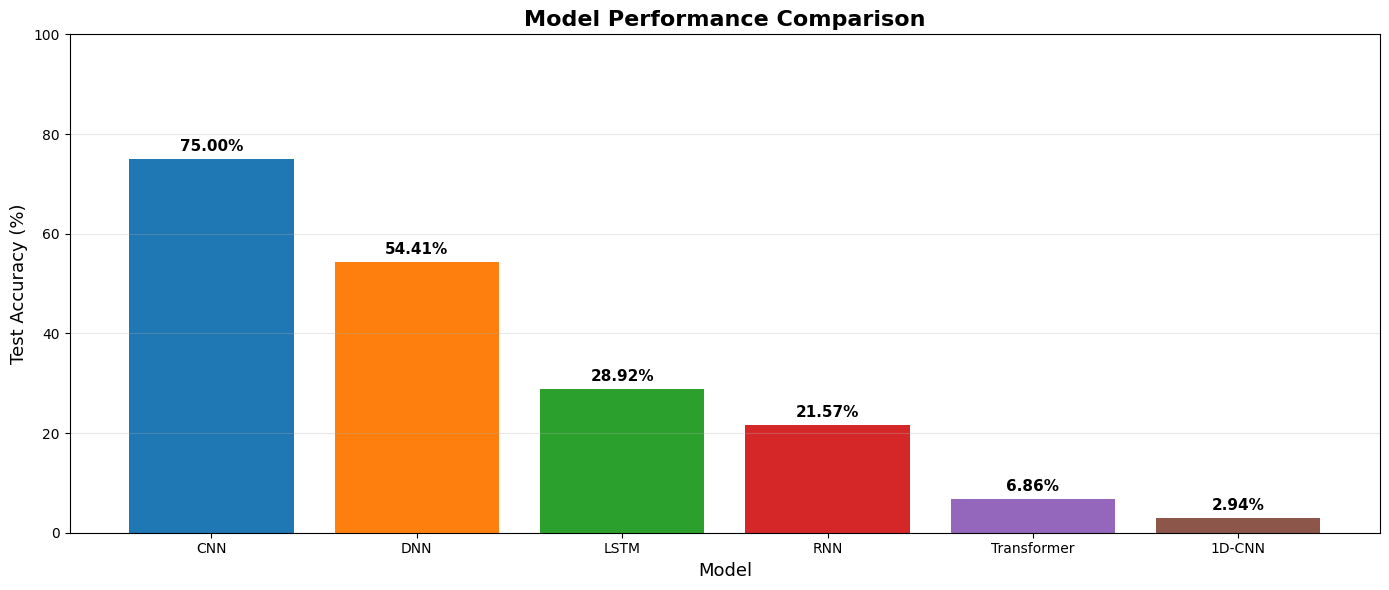

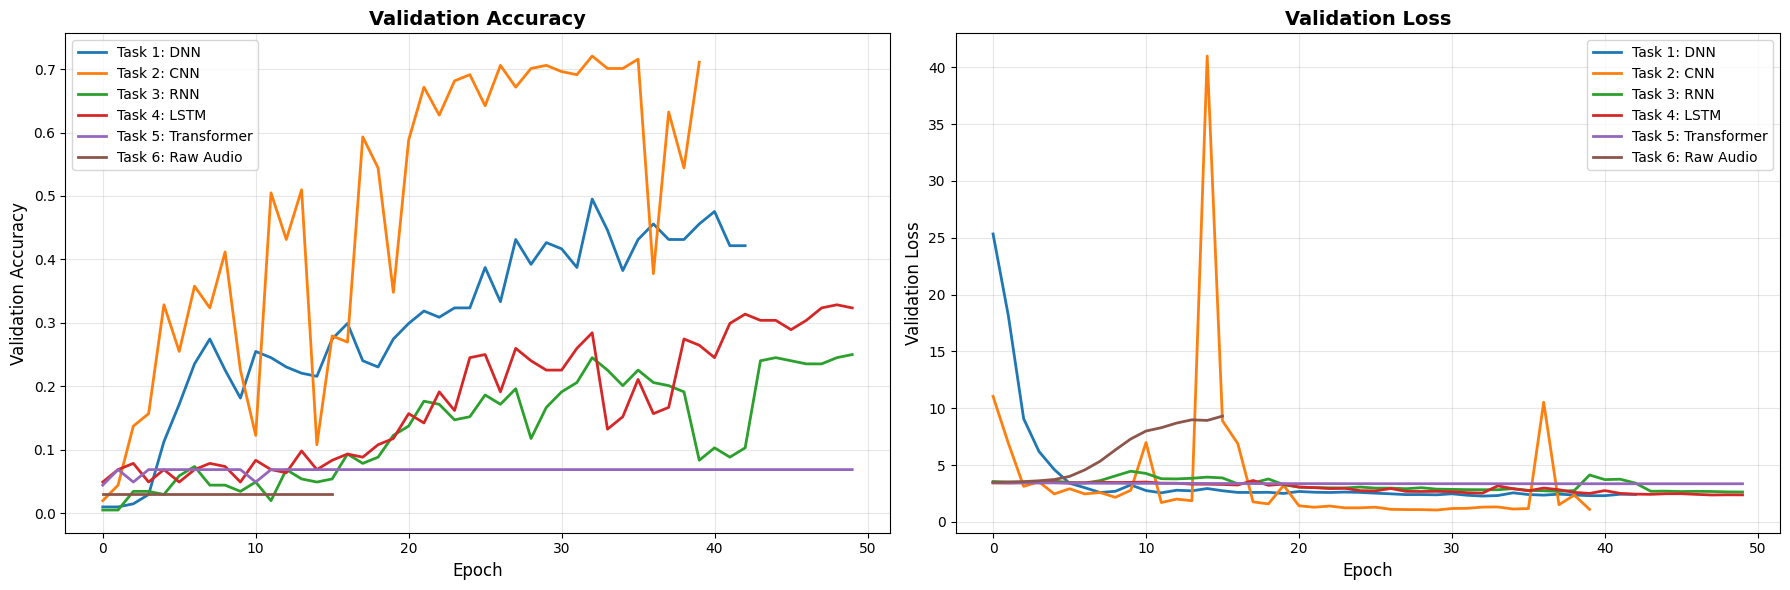

In [ ]:

print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)

results = {
    'Task': ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6'],
    'Model': ['DNN', 'CNN', 'RNN', 'LSTM', 'Transformer', '1D-CNN'],
    'Accuracy': [acc_dnn, acc_cnn, acc_rnn, acc_lstm, acc_transformer, acc_raw],
    'Input Type': [
        'Flattened Spectrogram',
        'Spectrogram (2D)',
        'Spectrogram (Sequence)',
        'Spectrogram (Sequence)',
        'Spectrogram (Sequence)',
        'Raw Waveform'
    ]
}

results_df = pd.DataFrame(results)
results_df['Accuracy (%)'] = results_df['Accuracy'] * 100
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("\n")
print(results_df.to_string(index=False))
print("\n" + "="*70)

print(f"\nBest Model: {results_df.iloc[0]['Model']} - {results_df.iloc[0]['Accuracy (%)']:.2f}%")
print(f"Worst Model: {results_df.iloc[-1]['Model']} - {results_df.iloc[-1]['Accuracy (%)']:.2f}%")

plt.figure(figsize=(14, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bars = plt.bar(results_df['Model'], results_df['Accuracy (%)'], color=colors)
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=13)
plt.ylabel('Test Accuracy (%)', fontsize=13)
plt.ylim([0, 100])
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(history_dnn.history['val_accuracy'], label='Task 1: DNN', linewidth=2)
axes[0].plot(history_cnn.history['val_accuracy'], label='Task 2: CNN', linewidth=2)
axes[0].plot(history_rnn.history['val_accuracy'], label='Task 3: RNN', linewidth=2)
axes[0].plot(history_lstm.history['val_accuracy'], label='Task 4: LSTM', linewidth=2)
axes[0].plot(history_transformer.history['val_accuracy'], label='Task 5: Transformer', linewidth=2)
axes[0].plot(history_raw.history['val_accuracy'], label='Task 6: Raw Audio', linewidth=2)
axes[0].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Validation Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_dnn.history['val_loss'], label='Task 1: DNN', linewidth=2)
axes[1].plot(history_cnn.history['val_loss'], label='Task 2: CNN', linewidth=2)
axes[1].plot(history_rnn.history['val_loss'], label='Task 3: RNN', linewidth=2)
axes[1].plot(history_lstm.history['val_loss'], label='Task 4: LSTM', linewidth=2)
axes[1].plot(history_transformer.history['val_loss'], label='Task 5: Transformer', linewidth=2)
axes[1].plot(history_raw.history['val_loss'], label='Task 6: Raw Audio', linewidth=2)
axes[1].set_title('Validation Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The result:

The CNN achieved the highest accuracy (75.00%) because spectrograms behave like images, and CNNs are good at finding patterns in 2D data. This allowed the model to recognize shapes in whale and dolphin sounds much better than the other methods. The DNN performed reasonably (54.41%) because it could learn from the flattened spectrogram features, though it lost some spatial structure. RNNs and LSTMs performed poorly (21.57% and 28.92%) because they read the spectrogram only as a sequence, which does not capture both time and frequency information well. The Transformer failed completely (6.86%) despite its attention mechanism, showing that attention alone cannot compensate for lack of spatial processing in 2D data.

The raw audio model had the lowest accuracy (2.94%) because waveforms are too complex to learn from directly without converting them into spectrograms. Overall, the results show that spectrogram-based CNN models work best for marine mammal sound classification, while sequence models and raw waveform approaches are not effective for this dataset.